introduction

This analysis, which concerns the period from 2020 until the present, is based on the summary data about the weekly excess deaths, among which there are total deaths, deaths due to COVID-19, and expected deaths for various regions. Our paramount goal here is to figure out the influence of COVID-19 on mortality and also identify any major statistical trends or anomalies from the data. With the data cleaning, transformation, and feature engineering as a preparation phase, we proceed to the detailed analysis of the data as part of the model exploratory process and finally to the predictive modeling. The acquired knowledge through this section is aimed to guide public health measures and deepening the knowledge of the outbreak's essence.

In [18]:
#importimg necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



cleaning and preprocessiong the dataset

In [19]:

#data cleaning and preprocessing
data = pd.read_csv("all_weekly_excess_deaths.csv")

# Concerting the dates into datetime format
data['start_date'] = pd.to_datetime(data['start_date'])
data['end_date'] = pd.to_datetime(data['end_date'])

# here we checked for missing values
print(data.isnull().sum())

# Finally filling in the missing values with mean
numeric_cols = data.select_dtypes(include=['number'])
data[numeric_cols.columns] = numeric_cols.fillna(numeric_cols.mean())

# Handling outliers with Z-score for 'total_deaths'
data['zscore_total_deaths'] = zscore(data['total_deaths'])
data = data[data['zscore_total_deaths'].abs() <= 3]  # Assuming 3 standard deviations

# here we normalized and got the data to get the data to be in the same scale
scaler = StandardScaler()
data['normalized_total_deaths'] = scaler.fit_transform(data[['total_deaths']])

# Feature engineering: extracting month from 'start_date'
data['month'] = data['start_date'].dt.month

# lastly we have the cleaned dataset
data.to_csv("cleaned_dataset.csv", index=False)


country                     0
region                      0
region_code                 0
start_date                  0
end_date                    0
days                        0
year                        0
week                        0
population                  0
total_deaths                0
covid_deaths                0
expected_deaths             0
excess_deaths               0
non_covid_deaths            0
covid_deaths_per_100k       0
excess_deaths_per_100k      0
excess_deaths_pct_change    0
dtype: int64


data exploration

descriptive analysis

In [20]:

print(data.describe())

print(data.describe(include=['object', 'category']))


       region_code                     start_date  \
count       5640.0                           5640   
mean           0.0  2021-03-13 13:38:02.553191424   
min            0.0            2019-12-28 00:00:00   
25%            0.0            2020-08-03 00:00:00   
50%            0.0            2021-03-08 00:00:00   
75%            0.0            2021-10-18 00:00:00   
max            0.0            2022-07-17 00:00:00   
std            0.0                            NaN   

                            end_date    days         year         week  \
count                           5640  5640.0  5640.000000  5640.000000   
mean   2021-03-19 13:38:02.553191424     7.0  2020.750000    24.231028   
min              2020-01-03 00:00:00     7.0  2020.000000     1.000000   
25%              2020-08-09 00:00:00     7.0  2020.000000    11.000000   
50%              2021-03-14 00:00:00     7.0  2021.000000    22.000000   
75%              2021-10-24 00:00:00     7.0  2021.000000    37.000000   
max 

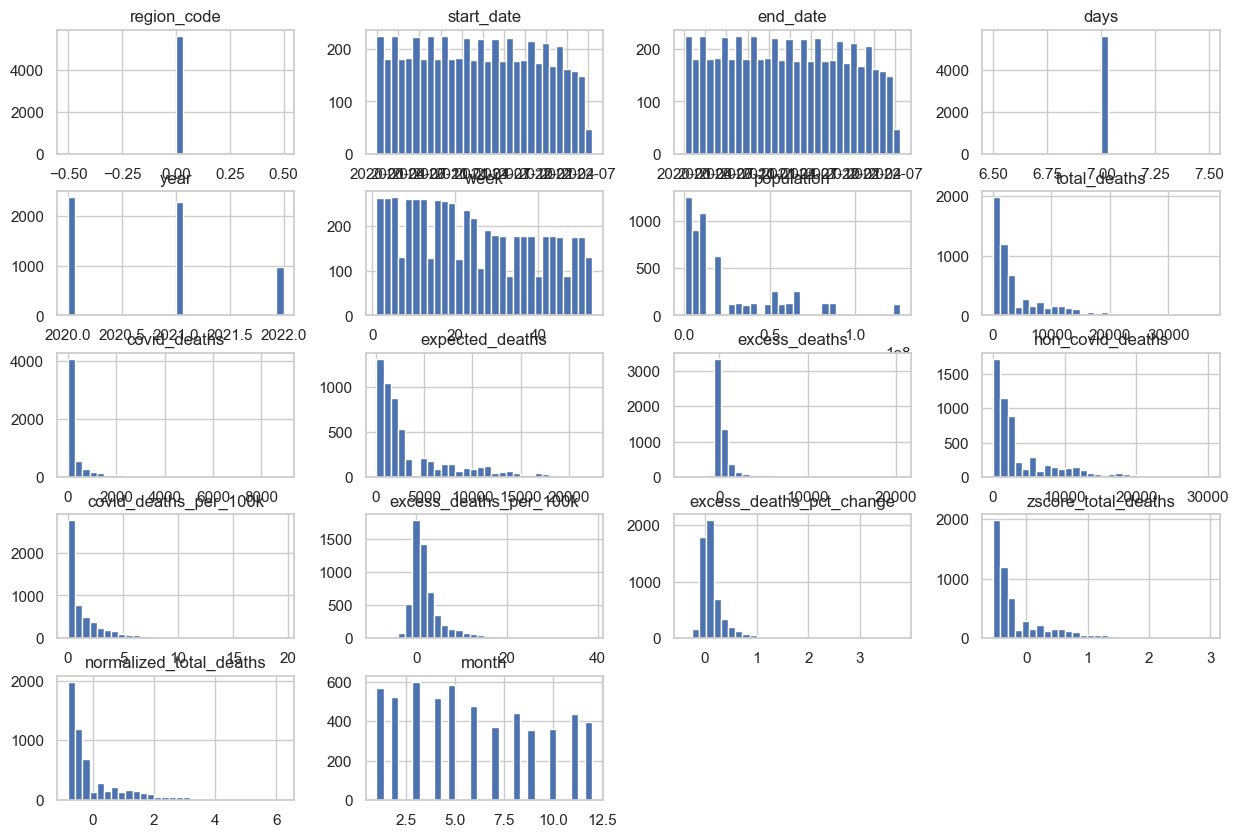

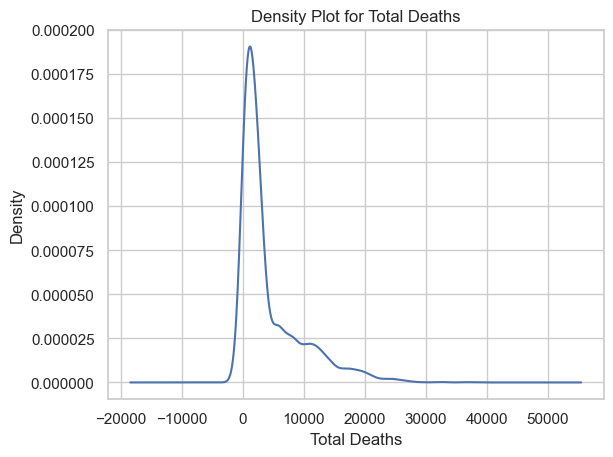

In [21]:
# Histograms for all numeric data across the dataset
data.hist(bins=30, figsize=(15, 10))
plt.show()
# Density plots for understanding the distribution shape
data['total_deaths'].plot(kind='density')
plt.title('Density Plot for Total Deaths')
plt.xlabel('Total Deaths')
plt.show()

correlation analysis

In [22]:
#heere we are selecting the numeric data and calculating the correlation matrix
numeric_data = data.select_dtypes(include=[np.number])  
corr_matrix = numeric_data.corr()


print(corr_matrix)


                          region_code  days      year      week  population  \
region_code                       NaN   NaN       NaN       NaN         NaN   
days                              NaN   NaN       NaN       NaN         NaN   
year                              NaN   NaN  1.000000 -0.290140    0.006742   
week                              NaN   NaN -0.290140  1.000000    0.002884   
population                        NaN   NaN  0.006742  0.002884    1.000000   
total_deaths                      NaN   NaN  0.009956  0.005217    0.910515   
covid_deaths                      NaN   NaN  0.013196  0.004287    0.533367   
expected_deaths                   NaN   NaN  0.022852 -0.030943    0.911011   
excess_deaths                     NaN   NaN -0.031076  0.104489    0.475583   
non_covid_deaths                  NaN   NaN  0.008631  0.005022    0.917451   
covid_deaths_per_100k             NaN   NaN  0.092998  0.043993   -0.013374   
excess_deaths_per_100k            NaN   NaN  0.02694

scatter plot of the data

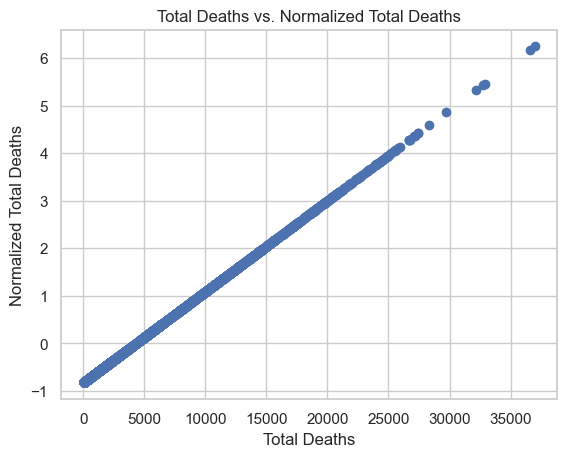

In [23]:
# Scatter plot between two variables
plt.scatter(data['total_deaths'], data['normalized_total_deaths'])
plt.title('Total Deaths vs. Normalized Total Deaths')
plt.xlabel('Total Deaths')
plt.ylabel('Normalized Total Deaths')
plt.show()



box plot of the data

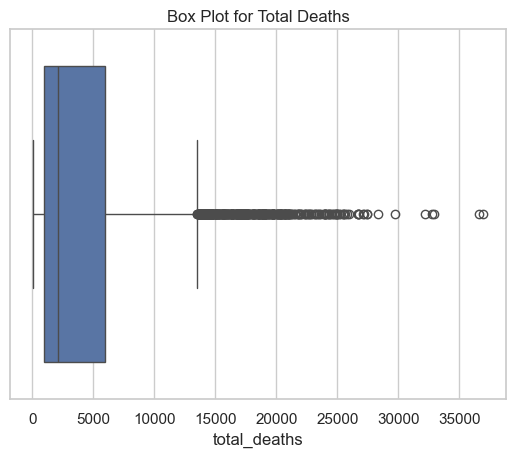

In [24]:
# Box plot for total deaths to view outliers
sns.boxplot(x=data['total_deaths'])
plt.title('Box Plot for Total Deaths')
plt.show()


time series analysis

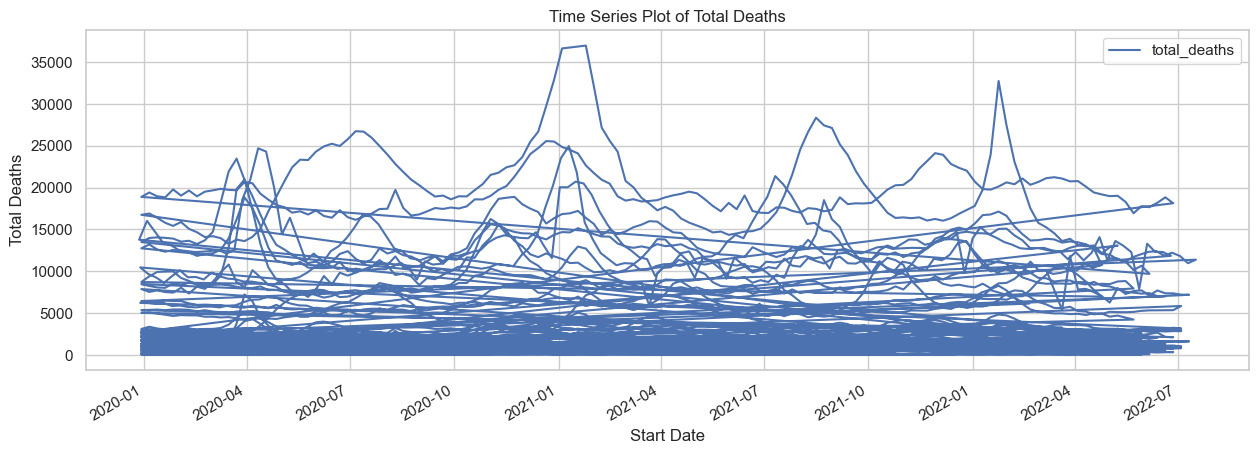

In [25]:
# Time series plot for total deaths over time
data.plot(x='start_date', y='total_deaths', style='-', figsize=(15, 5))
plt.title('Time Series Plot of Total Deaths')
plt.xlabel('Start Date')
plt.ylabel('Total Deaths')
plt.show()


Data Transformation and Feature Engineering

In [26]:
#in this code snippet adding new columns to the dataset and also standardizing the selected numerical columns
data['mortality_rate_per_capita'] = (data['total_deaths'] / data['population']) * 100000 
data['excess_mortality_rate_per_capita'] = (data['excess_deaths'] / data['population']) * 100000

# Standardizing selected numerical columns
scaler = StandardScaler()
numerical_columns = ['total_deaths', 'excess_deaths', 'expected_deaths', 'non_covid_deaths'] 
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Saving the transformed data
data.to_csv("transformed_dataset.csv", index=False)

 data mining and analysis

In [27]:


# Selecting features and target variable for the model
features = ['population', 'excess_deaths_per_100k', 'month']
target = 'total_deaths'  # Predicting total deaths


X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# here we are using the linear regression model to train the model
model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

# Calculating the mean squared error and R^2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing results
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")



Mean Squared Error: 0.13527996621685312
R^2 Score: 0.8667487146906513


visualization of the results

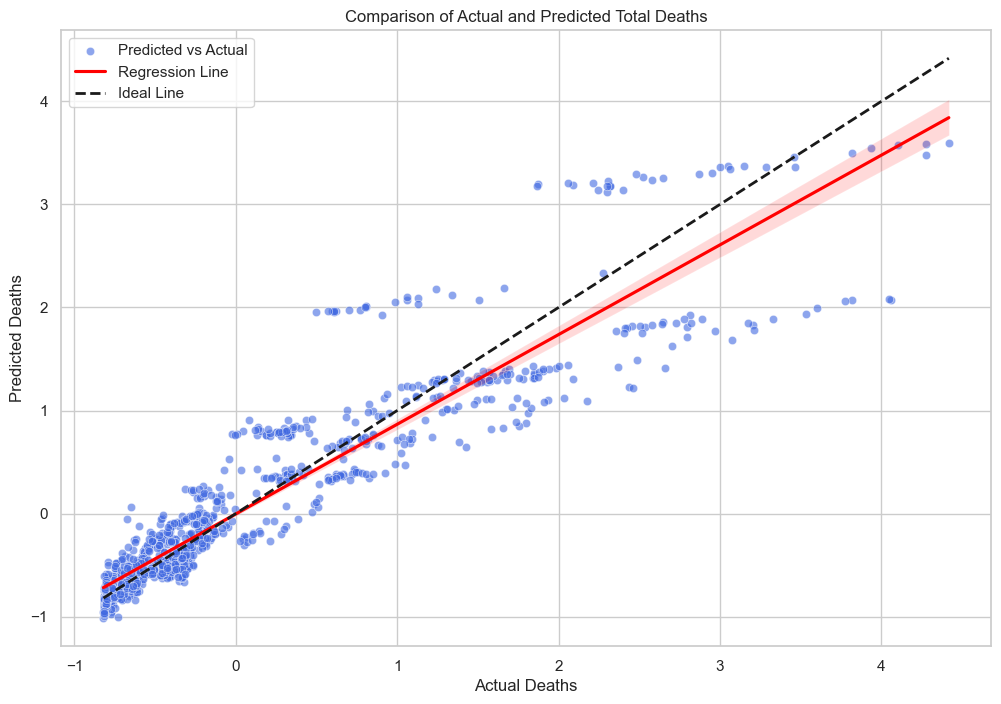

In [28]:
# Visual representation of the predictions
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.scatterplot(x=y_test, y=y_pred, color='royalblue', alpha=0.6, label='Predicted vs Actual')
sns.regplot(x=y_test, y=y_pred, scatter=False, color='red', label='Regression Line')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Line')
plt.xlabel('Actual Deaths')
plt.ylabel('Predicted Deaths')
plt.title('Comparison of Actual and Predicted Total Deaths')
plt.legend()
plt.show()

In [29]:
import joblib

# Assuming `model` is your trained model
joblib.dump(model, 'model.pkl')

['model.pkl']